<a href="https://colab.research.google.com/github/lee588779/A-hair-Disease-prediction-model/blob/main/the_severity_of_a_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/DATA2/archive/Hair Diseases - Final/train'
test_path = '/content/drive/MyDrive/DATA2/archive/Hair Diseases - Final/test'
val_path = '/content/drive/MyDrive/DATA2/archive/Hair Diseases - Final/val'

In [3]:
rn = MobileNetV2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

9420800/9406464 [==============================] - 0s 0us/step


In [4]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

get_available_gpus()

from tensorflow.python.client import device_lib

In [5]:
for layer in rn.layers:
    layer.trainable = False
    
folders = glob(train_path+'\*')

In [6]:
x = Flatten()(rn.output)

In [7]:
prediction = Dense(4, activation='softmax')(x)
model = Model(inputs=rn.input, outputs=prediction)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [14]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(directory=train_path,
                target_size = (224,224),
                batch_size = 64,
                class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(directory=test_path,
                target_size = (224,224),
                batch_size = 64,
                class_mode = 'categorical', shuffle=False)
val_set = val_datagen.flow_from_directory(directory=val_path,
                target_size = (224,224),
                batch_size = 64,
                class_mode = 'categorical', shuffle=False)

Found 1154 images belonging to 4 classes.
Found 1154 images belonging to 4 classes.
Found 1154 images belonging to 4 classes.


In [15]:
import keras
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
  loss='categorical_crossentropy',
  optimizer=opt,
  metrics=["acc"]
)

In [16]:
import time 
print(time.ctime())
from time import time
t_start = time()

Wed Jun 15 09:43:29 2022


In [17]:
import keras
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

annealer = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('/temp/{epoch}_MobileNetV2.h5', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')

In [18]:
history = model.fit(
                  training_set,
                  validation_data=val_set,
                  epochs=20,
                  batch_size=128,
                  callbacks=[annealer, checkpoint],
                  steps_per_epoch=len(training_set),
                  validation_steps=len(test_set)
                )

Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 12.7234 - acc: 0.4021 WARNING:tensorflow:Learning rate reduction is conditioned on metric `accuracy` which is not available. Available metrics are: loss,acc,val_loss,val_acc,lr

Epoch 1: saving model to /temp/1_MobileNetV2.h5
19/19 [==============================] - 494s 26s/step - loss: 12.7234 - acc: 0.4021 - val_loss: 4.0820 - val_acc: 0.6205 - lr: 0.0010
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 3.0732 - acc: 0.6603WARNING:tensorflow:Learning rate reduction is conditioned on metric `accuracy` which is not available. Available metrics are: loss,acc,val_loss,val_acc,lr

Epoch 2: saving model to /temp/2_MobileNetV2.h5
19/19 [==============================] - 80s 4s/step - loss: 3.0732 - acc: 0.6603 - val_loss: 0.9694 - val_acc: 0.8362 - lr: 0.0010
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.7875 - acc: 0.8423WARNING:tensorflow:Learning rate reduction is conditioned o

In [19]:
train_time = time() - t_start
print('\nTrain time: %.3f'%(train_time/60), ' mins')


Train time: 35.410  mins


In [20]:
model.save("MobileNetV2-Final.h5")
print("Model Saved as : MobileNetV2-Final.h5")

import json
np.save('my_history.npy',history.history)
import pandas as pd

# convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

Model Saved as : MobileNetV2-Final.h5


In [21]:
from time import time
start = time()
evl = model.evaluate(test_set)
test_time = time() - start

test_loss, test_acc = evl[0]*100, evl[1]*100

msg = f'Test Accuracy = {test_acc:5.2f} %'
msg1 = f'Test Loss = {test_loss:5.2f} %'
msg2 = f'Test Time = {test_time:5.2f} s'
print(msg)
print(msg1)
print(msg2)

19/19 [==============================] - 241s 13s/step - loss: 4.5039e-04 - acc: 1.0000
Test Accuracy = 100.00 %
Test Loss =  0.05 %
Test Time = 260.77 s


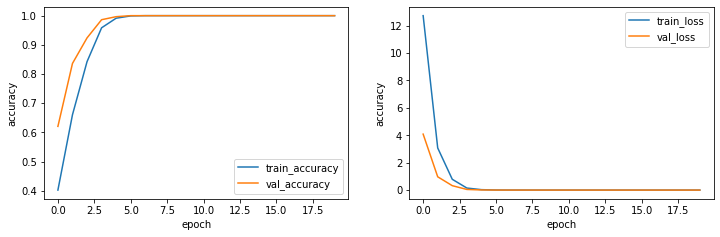

In [22]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(12, 12))
plt.subplot(3, 2, 1)
plt.plot(history.history['acc'], label = 'train_accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(3, 2, 2)
plt.plot(history.history['loss'], label = 'train_loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [23]:
import numpy as np

def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

True :  [0 0 0 ... 3 3 3]
Predicted :  [0 0 0 ... 3 3 3]


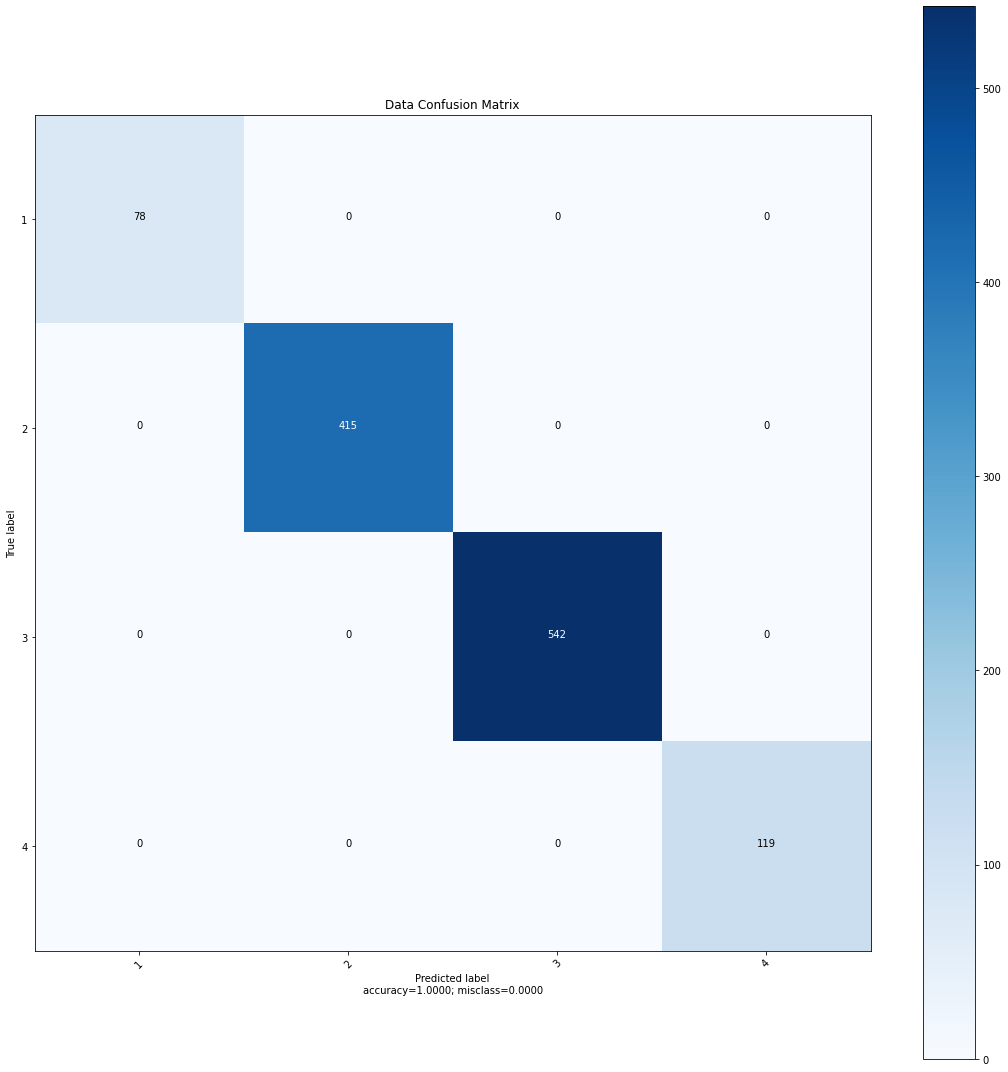

In [25]:
from sklearn.metrics import confusion_matrix

classes = ["1", "2", "3", "4"]

y_true = np.array(test_set.labels)
print("True : ", y_true)

y_pred = model.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
print("Predicted : ", y_pred)

conf_mat = confusion_matrix(y_true, y_pred)

plot_confusion_matrix(cm           = conf_mat,
                      normalize    = False,
                      target_names = classes,
                      title        = "Data Confusion Matrix")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')